# Plotting with `PyVista` and `K3D`

We are about to build a compound mesh by transforming parts of a voxlized cylinder into tetrahedra and lines. Then we do some plotting and review the basics of configuring plots.

In [36]:
from polymesh.space import CartesianFrame
from polymesh.recipes import cylinder
from polymesh import PolyData, LineData, PointData
from polymesh.cells import H8, Q4, L2
from polymesh.utils.topology import H8_to_L2, H8_to_Q4
from polymesh.utils.topology import detach_mesh_bulk
from polymesh.utils.space import frames_of_lines, frames_of_surfaces
from neumann import minmax
import numpy as np

min_radius = 5
max_radius = 25
h = 50
angle = 1

shape = (min_radius, max_radius), angle, h
frame = CartesianFrame(dim=3)
cyl = cylinder(shape, size=5.0, voxelize=True, frame=frame)

coords = cyl.coords()
topo = cyl.topology()
centers = cyl.centers()

cxmin, cxmax = minmax(centers[:, 0])
czmin, czmax = minmax(centers[:, 2])
cxavg = (cxmin + cxmax) / 2
czavg = (czmin + czmax) / 2
b_upper = centers[:, 2] > czavg
b_lower = centers[:, 2] <= czavg
b_left = centers[:, 0] < cxavg
b_right = centers[:, 0] >= cxavg
iL2 = np.where(b_upper & b_right)[0]
iTET4 = np.where(b_upper & b_left)[0]
iH8 = np.where(b_lower)[0]
_, tL2 = H8_to_L2(coords, topo[iL2])
_, tQ4 = H8_to_Q4(coords, topo[iTET4])
tH8 = topo[iH8]

pd = PointData(coords=coords, frame=frame)
mesh = PolyData(pd, frame=frame)

cdL2 = L2(topo=tL2, frames=frames_of_lines(coords, tL2))
mesh["lines", "L2"] = LineData(cdL2, frame=frame)

cdQ4 = Q4(topo=tQ4, frames=frames_of_surfaces(coords, tQ4))
mesh["surfaces", "Q4"] = PolyData(cdQ4, frame=frame)

cH8, tH8 = detach_mesh_bulk(coords, tH8)
pdH8 = PointData(coords=cH8, frame=frame)
cdH8 = H8(topo=tH8, frames=frame)
mesh["bodies", "H8"] = PolyData(pdH8, cdH8, frame=frame)

mesh.to_standard_form()
mesh.lock(create_mappers=True)

PolyData({'lines': PolyData({'L2': PolyData({})}), 'surfaces': PolyData({'Q4': PolyData({})}), 'bodies': PolyData({'H8': PolyData({})})})

## Plotting with `PyVista`

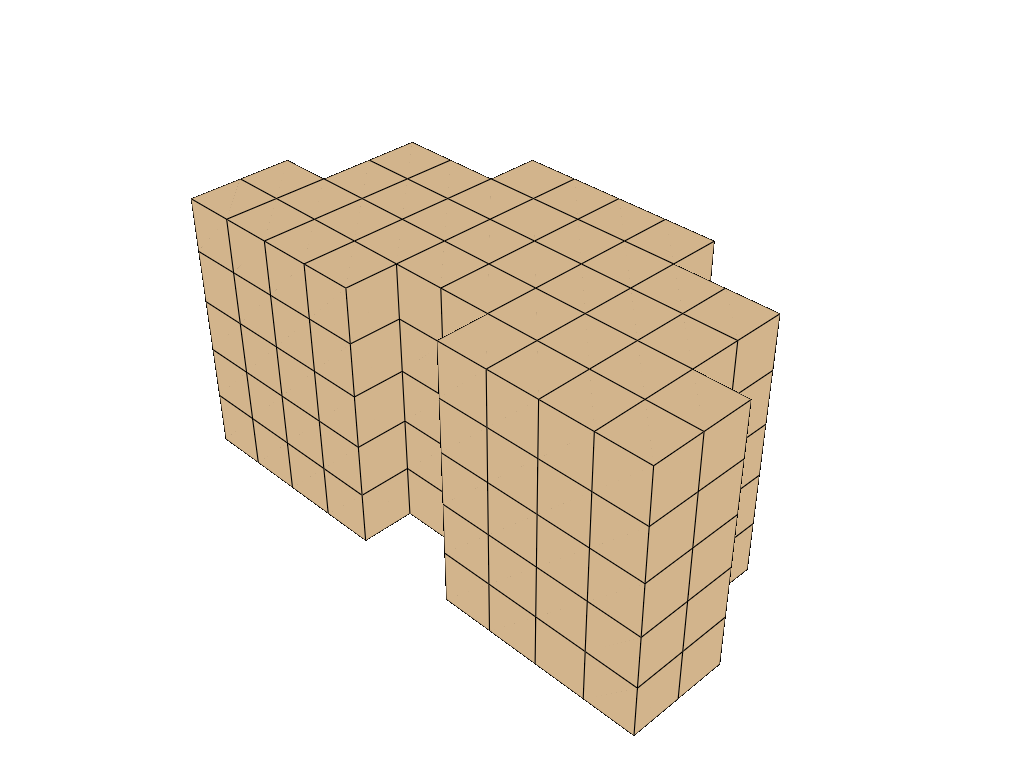

In [37]:
mesh["surfaces", "Q4"].plot(
    notebook=True,
    jupyter_backend="static",
    show_edges=True,
    theme="document",
)

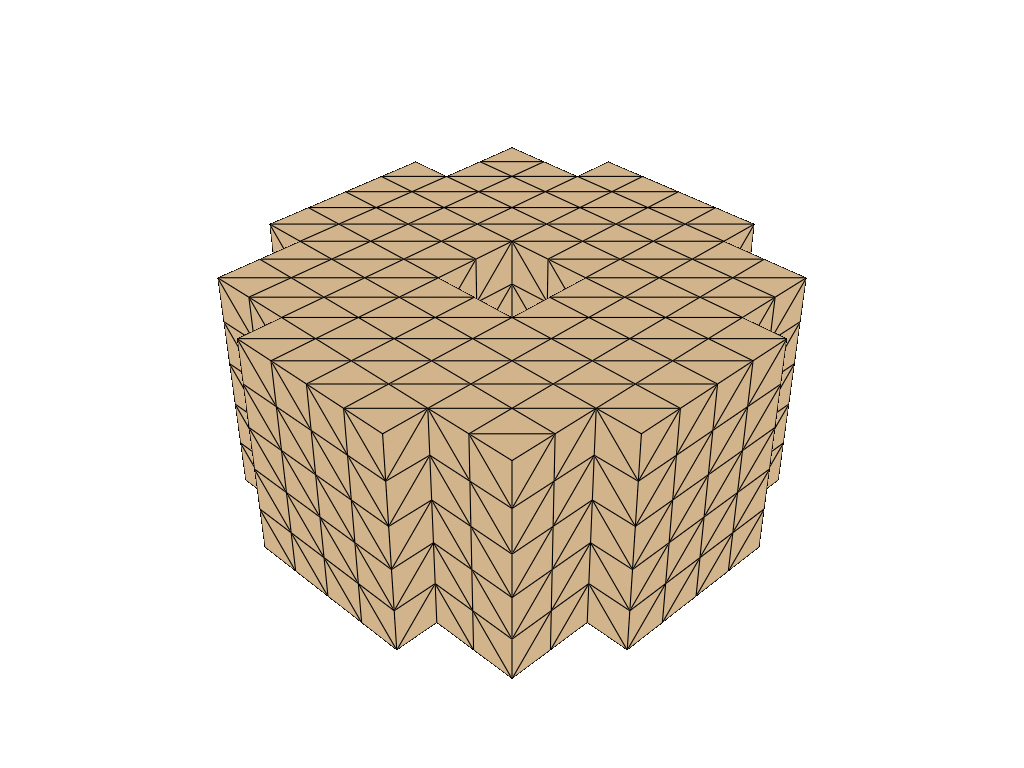

In [38]:
mesh["bodies", "H8"].surface().pvplot(
    notebook=True,
    jupyter_backend="static",
    show_edges=True,
    theme="document",
)

### Plotting with Data

Add some configuration to the `PyVista` plotting mechanism. This requires to think about
a ``config_key``, that later we can use to point at our configuration. The configurations
are stored in the ``config`` attribute of each block we are about to plot. For example,
to set some basic properties:

In [39]:
mesh["lines", "L2"].config["pyvista", "plot", "color"] = "red"
mesh["lines", "L2"].config["pyvista", "plot", "line_width"] = 1.5
mesh["lines", "L2"].config["pyvista", "plot", "render_lines_as_tubes"] = True

mesh["surfaces", "Q4"].config["pyvista", "plot", "show_edges"] = True
mesh["surfaces", "Q4"].config["pyvista", "plot", "color"] = "yellow"
mesh["surfaces", "Q4"].config["pyvista", "plot", "opacity"] = 0.3

mesh["bodies", "H8"].config["pyvista", "plot", "show_edges"] = True
mesh["bodies", "H8"].config["pyvista", "plot", "color"] = "cyan"
mesh["bodies", "H8"].config["pyvista", "plot", "opacity"] = 1.0

The following block shows how to refer to the previously set config. 

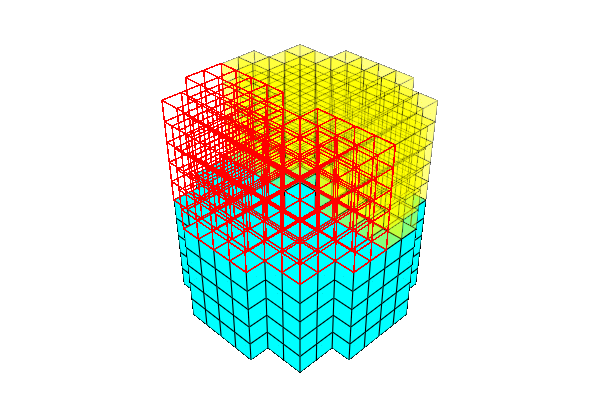

In [40]:
mesh.pvplot(
    notebook=True,
    jupyter_backend="static",
    cmap="plasma",
    window_size=(600, 400),
    config_key=["pyvista", "plot"],
    theme="document",
)

We can assign colors by setting numerical data on points or cells. All we have to do
is to provide the keyword argument ``scalars`` to `PyVista`. One way to do that is to
add these walues to the configuration of your block of choice. For example, to set random data on H8 hexagonals, do this:

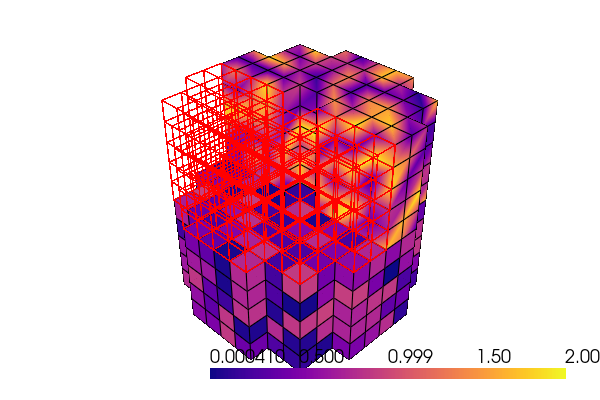

In [41]:
mesh["bodies", "H8"].config["pyvista", "plot", "scalars"] = np.random.rand(tH8.shape[0])
ncTET4 = mesh["surfaces", "Q4"].coords(from_cells=True).shape[0]
mesh["surfaces", "Q4"].config["pyvista", "plot", "scalars"] = 2 * np.random.rand(ncTET4)
mesh["surfaces", "Q4"].config["pyvista", "plot", "opacity"] = 1.0
mesh.pvplot(
    notebook=True,
    jupyter_backend="static",
    window_size=(600, 400),
    config_key=["pyvista", "plot"],
    cmap="plasma",
    theme="document",
)

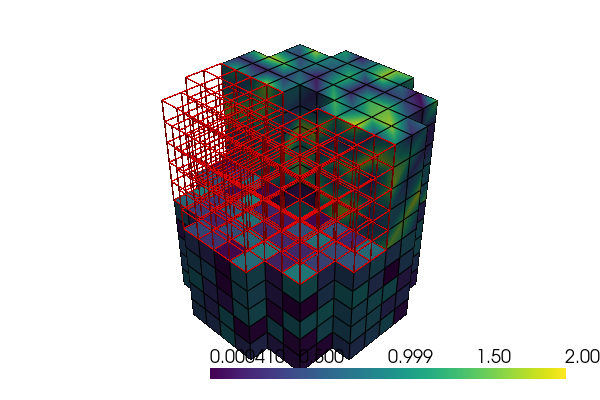

In [42]:
import pyvista as pv

plotter = pv.Plotter(theme=pv.themes.DocumentTheme())
plotter = mesh.pvplot(
    plotter=plotter,
    config_key=["pyvista", "plot"],
    return_plotter=True,
)
plotter.show(jupyter_backend="static", window_size=(600, 400))

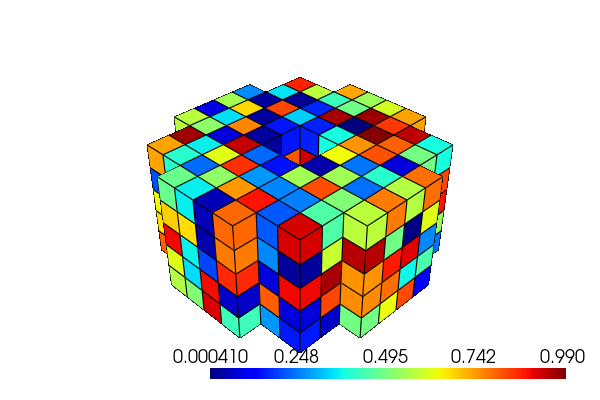

In [43]:
block = mesh.blocks_of_cells(2345)[2345]
block.pvplot(
    notebook=True,
    jupyter_backend="static",
    window_size=(600, 400),
    config_key=["pyvista", "plot"],
    cmap="jet",
    theme="document",
)

## Plotting with `K3D`

(The outputs of the following blocks might fail to show properly. Download the notebook and try it for yourself.)

In [44]:
from k3d import matplotlib_color_maps

mesh["lines", "L2"].config["k3d", "plot", "color"] = "red"
mesh["lines", "L2"].config["k3d", "plot", "width"] = 0.2

mesh["surfaces", "Q4"].config["k3d", "plot", "color"] = "yellow"
mesh["surfaces", "Q4"].config["k3d", "plot", "opacity"] = 0.3

mesh["bodies", "H8"].config["k3d", "plot", "color"] = "cyan"
mesh["bodies", "H8"].config["k3d", "plot", "opacity"] = 1.0

In [45]:
mesh["lines", "L2"].k3dplot(config_key=["k3d", "plot"], menu_visibility=False)

f:\GitHub\dewloosh\PolyMesh\.polymesh\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [46]:
plot = mesh.k3dplot(config_key=["k3d", "plot"], menu_visibility=False)
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [47]:
mesh["lines", "L2"].cd.db["scalars"] = 100 * np.random.rand(len(cdL2))
mesh["surfaces", "Q4"].cd.db["scalars"] = 100 * np.random.rand(len(cdQ4))
mesh["bodies", "H8"].cd.db["scalars"] = 100 * np.random.rand(len(cdH8))
scalars = mesh.pd.pull("scalars")

In [48]:
from k3d.colormaps import matplotlib_color_maps

cmap = matplotlib_color_maps.Jet
plot = mesh.k3dplot(scalars=scalars, menu_visibility=False, cmap=cmap)
plot

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

The K3D library lets you save the content directly into html with or without the necessary javascript included:

In [49]:
with open("k3d.html", "w") as f:
    plot.snapshot_include_js = True
    f.write(plot.get_snapshot())